# SDWFS Cutout Footprints
## Author: Benjamin Floyd

Shows the positions of the SDWFS cutouts used as the background sample in the SPTcl-IRAGN study.

In [96]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import imshow_norm, ZScaleInterval, LinearStretch
from astropy.visualization.wcsaxes import Quadrangle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.table import Table
import astropy.units as u
import numpy as np


%matplotlib inline

In [97]:
# Read in the full SDWFS image that we will use as the backdrop
I1_SDWFS_img, I1_SDWFS_hdr = fits.getdata('Data_Repository/Images/Bootes/SDWFS/I1_bootes.v32.fits', header=True)
I1_SDWFS_wcs = WCS(I1_SDWFS_hdr)

In [114]:
# Read in the SDWFS-IRAGN catalog
sdwfs_iragn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')
sdwfs_iragn_grp = sdwfs_iragn.group_by('CUTOUT_ID')

# Get the mask WCSs
mask_wcss = [WCS(cutout['MASK_NAME'][0]) for cutout in sdwfs_iragn_grp.groups]

# Get the cutout centers
cutout_centers = {cutout['CUTOUT_ID'][0]: (cutout['SZ_RA'][0] * u.deg, cutout['SZ_DEC'][0] * u.deg) for cutout in sdwfs_iragn_grp.groups}
cutout_anchors = [np.array(I1_SDWFS_wcs.wcs_world2pix(cutout_center[0].value, cutout_center[1].value, 0)) - np.array(mask_wcs.pixel_shape) / 2 for cutout_center, mask_wcs in zip(cutout_centers.values(), mask_wcss)]

In [109]:
from ds9_region import ds9_coord
ds9_coord(sdwfs_iragn_grp.groups[12], outfname='/Users/btfkwd/Desktop/SDWFS_cutout_012_AGN.reg', color='magenta', radius=4, system='fk5', shape='circle', width=1, ra_col='ALPHA_J2000', dec_col='DELTA_J2000')

In [103]:
cutout_012_hdr = fits.getheader(sdwfs_iragn_grp.groups[12]['MASK_NAME'][0])
I1_SDWFS_wcs.wcs_pix2world(np.abs(cutout_012_hdr['LTV1']) + cutout_012_hdr['NAXIS1'] / 2, np.abs(cutout_012_hdr['LTV2']) + cutout_012_hdr['NAXIS2'] / 2, 1)

[array(219.35291071), array(34.3387445)]

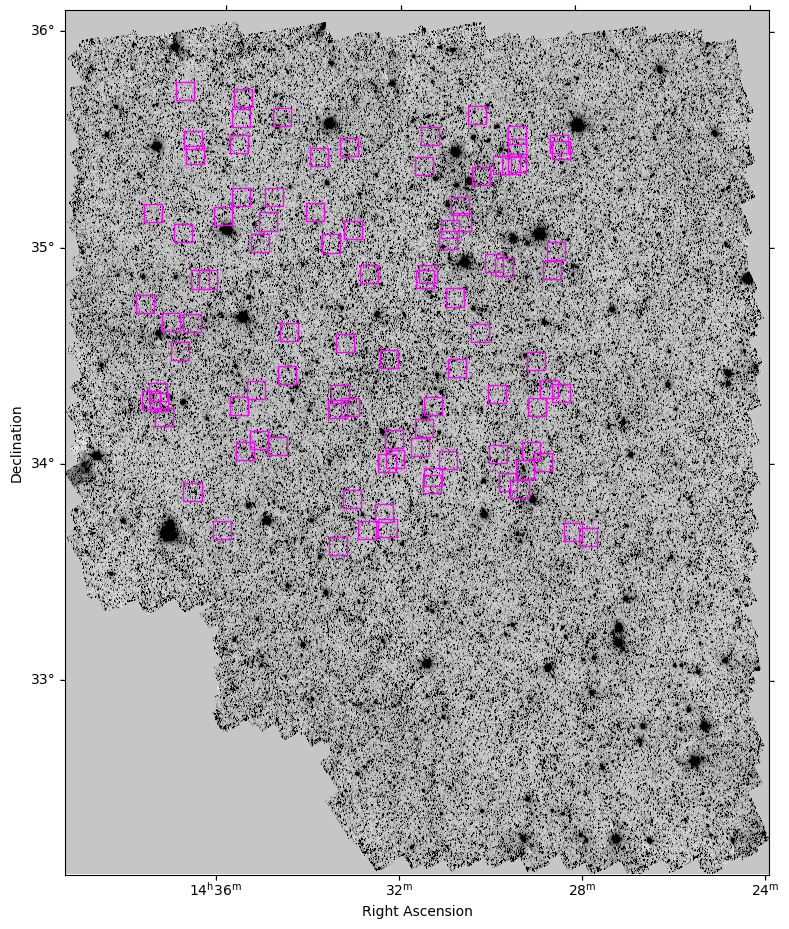

In [118]:
# Make the plot
fig, ax = plt.subplots(figsize=(8, 12), subplot_kw=dict(projection=I1_SDWFS_wcs))
imshow_norm(I1_SDWFS_img, origin='lower', stretch=LinearStretch(), interval=ZScaleInterval(), cmap='Greys', ax=ax)

# Generate the quadrangles that are the cutout footprints
cutout_footprints = [Rectangle(cutout_anchor, width=mask_wcs.pixel_shape[0], height=mask_wcs.pixel_shape[1], edgecolor='magenta', facecolor='none', lw=1) for mask_wcs, cutout_anchor in zip(mask_wcss, cutout_anchors)]
for footprint in cutout_footprints:
    ax.add_patch(footprint)

# anchor = np.array(I1_SDWFS_wcs.wcs_world2pix(cutout_centers['SDWFS_cutout_012'][0].value, cutout_centers['SDWFS_cutout_012'][1].value, 0)) - np.array(mask_wcss[12].pixel_shape)/2

# r = Rectangle(anchor, width=mask_wcss[12].pixel_shape[0], height=mask_wcss[12].pixel_shape[1], edgecolor='magenta', facecolor='none')
# ax.add_patch(r)
# q = Quadrangle(anchor, width=mask_wcss[12].pixel_shape[0], height=mask_wcss[12].pixel_shape[1], edgecolor='cyan', facecolor='none', vertex_unit='')
# ax.add_patch(q)

# Add the Cutout IDs on the centers of the footprints
# for cutout_id, cutout_center in cutout_centers.items():
#     ax.text(cutout_center[0].value, cutout_center[1].value, s=cutout_id[-3:], transform=ax.get_transform('world'), ha='center', va='center')

# ax.scatter([ra.value for ra, _ in cutout_centers.values()], [dec.value for _, dec in cutout_centers.values()], transform=ax.get_transform('world'))

ax.set(xlabel='Right Ascension', ylabel='Declination')
plt.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/Plots/SDWFS_cutout_footprint.pdf', dpi=500)